In [1]:
import svgwrite
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import pandas as pd
from sklearn.linear_model import LinearRegression
from utils import create_window,split_train_test

In [2]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

## DATA

### Functions to draw data

- In draw_strokes(), the first 20 data points are written in black and the rest of the data is drawn in brown. This value(20) is a constant, which can be varied for further experimentation. 

In [3]:
# helper function for draw_strokes
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in xrange(len(data)):
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)
    
    return (min_x, max_x, min_y, max_y)

# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=2, svg_filename = 'sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(0,20):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "red"
    stroke_width = 2
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    for i in xrange(20,len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=15.0):
    
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
  
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)
#test_set = np.load(data_dir, encoding='latin1', allow_pickle=True)
# get a sample drawing from the test set, and render it to .svg

70000
2500
2500


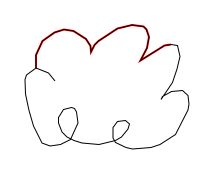

In [4]:
#Focus on cloud for the begining
data_dir = 'cloud.npz'

load_data = np.load(data_dir, encoding='latin1', allow_pickle=True) #specific to python3
train_set = load_data['train']
valid_set = load_data['valid']
test_set = load_data['test']

print (len(train_set))
print (len(valid_set))
print (len(test_set))

draw_strokes(random.choice(test_set))

In [5]:
#all_windows = create_window(train_set[0],5)
#all_windows

## Prepping the data

- each data in the train set is a 2 dimensional numpyarray with 3 values (x_pixel,y_pixel,[penup=1,pendown=0]) 

- The following steps are done for all samples in the train set
    - we take each sample from the train set
    - create windows of length 20 [create_window() is written by George]
    - save a set of 20 points as train_X
    - save the corresponding 21st point from the set as the value to predict i.e train_y
    - iterate through the entire sample

In [6]:
train_set[0]

array([[   1,  -42,    0],
       [   5,  -10,    0],
       [  28,  -21,    0],
       [  29,   -8,    0],
       [  47,    1,    0],
       [  19,   10,    0],
       [   2,   12,    0],
       [ -11,   15,    0],
       [  10,    2,    0],
       [  92,   -5,    0],
       [ 137,    0,    0],
       [   3,    5,    0],
       [  -7,    3,    0],
       [ -16,   17,    0],
       [ 130,   -1,    0],
       [   6,    5,    0],
       [  -1,   13,    0],
       [  -4,    9,    0],
       [ -22,   22,    0],
       [  50,   -4,    0],
       [  68,    2,    0],
       [  19,   12,    0],
       [   9,   18,    0],
       [  -2,   24,    0],
       [ -15,   19,    0],
       [ -32,   17,    0],
       [ -29,   20,    0],
       [ -20,   10,    0],
       [ -16,    4,    0],
       [  22,    0,    0],
       [   3,    5,    0],
       [  -2,    6,    0],
       [ -17,   15,    0],
       [-134,   68,    0],
       [ -24,    6,    0],
       [ -31,    0,    0],
       [  -9,   -3,    0],
 

In [7]:
# Note: it takes a long time to fit the model on the entire data
train_X = []
train_y = []

for i in range(len(train_set)-1):
    all_windows = create_window(train_set[i],20)
    
    for j in range(len(all_windows)-1):
        
        X,y = all_windows[j],all_windows[j+1][-1]
        train_X.append(X)
        train_y.append(y)
    break

In [12]:
train_X[0].shape

(20, 3)

In [13]:
train_X = np.array(train_X)
nsamples,nx,ny = train_X.shape

In [14]:
# Since scikit learn requires data with a maximum of 2 dimensions we reshape it
# reshaped data with dimensions = 2
d2_train_dataset = train_X.reshape((nsamples,nx*ny))

In [21]:
d2_train_dataset[0]

array([  1., -42.,   0.,   5., -10.,   0.,  28., -21.,   0.,  29.,  -8.,   0.,  47.,   1.,   0.,  19.,  10.,   0.,   2.,  12.,   0., -11.,  15.,   0.,  10.,   2.,   0.,  92.,  -5.,   0., 137.,   0.,
         0.,   3.,   5.,   0.,  -7.,   3.,   0., -16.,  17.,   0., 130.,  -1.,   0.,   6.,   5.,   0.,  -1.,  13.,   0.,  -4.,   9.,   0., -22.,  22.,   0.,  50.,  -4.,   0.])

## Training the model

- Here we use a Linear_regression with the intuition being to pass a regression line
- This is a very simple approach with room to improve


In [22]:
#Create a RandomForestRegressor model with the required hyperparameters
model = LinearRegression()

#Fit the training data (reshaped training data,y)
model.fit(d2_train_dataset, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Prediction

After obtaining a test sample, the following is performed
- reshape the test sample to match the training data
- Since our predicts only the next point in the sequence, we append the result each time to the original test sample.
- After appending we predict on the latest 20 points and repeat these steps for 100 times 

In [24]:
test_sample = test_set[990][:20]
new_sample = test_sample.reshape((1,nx*ny))
new_sample

array([[-11,  37,   0,   4,  33,   0,  13,  11,   0,  20,   9,   0,  45,  -3,   0,  13, -15,   0,   9, -31,   0,   3, -61,   0,  -5, -12,   0, -10,  -3,   0, -12,   1,   0,  -3,   6,   0,   3,  18,
          0,  19,  18,   0,  31,  14,   0,  38,   8,   0,  26,   0,   0,  21,  -7,   0,  11, -10,   0,   5, -16,   0]], dtype=int16)

In [25]:
for i in range(100):

    # get the last 20 samples (20*3 datapoints = 60)
    yhat = model.predict(np.array([new_sample[0][-60:]]))
    
    # we round off the output to remove decimals
    yhat[0][0] = round(yhat[0][0])
    yhat[0][1] = round(yhat[0][1])
    yhat[0][2] = round(yhat[0][2])
    
    #append the prediction to sample
    new_sample = np.append(new_sample,yhat)

    #to retain dimension of the sample
    new_sample = np.array([new_sample])

Our prediction


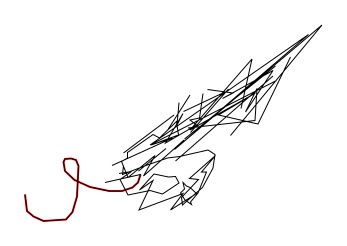

In [26]:
#since the predicted sample was flattened, reshape it back to (number of datapoints,3)
new_sample = new_sample.reshape(int(len(new_sample[0])/3),3)

print("Our prediction")
#draw the prediction
draw_strokes(new_sample)

Test data


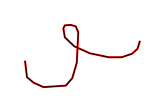

In [27]:
print("Test data")
draw_strokes(test_sample)

In [ ]:
#regression : prediction is the average prediction across the trees in the ensemble
#classification: prediction is the majority vote for the class label across the tree in the ensemble